# XPN 885 Greatest Songs by Women

It's countdown time at [XPN](https://xpn.org).
This year it's the [885 Greatest Songs by Women](https://xpn.org/countdown/885-greatest-songs-by-women/).
The stations is stepping up its [stats game](https://xpn.org/885-greatest-songs-by-women-by-the-numbers/),
so I'm not sure how much value I'll add.
With only 885 tracks, compared with last year's 90's A-Z 2133 tracks, it may be a challenge.
But we'll see what we can do.

In [1]:
%matplotlib inline
from IPython.display import display, HTML

## Status

It's Monday, Dec 11, and we're into the top 250

- updated [Data Loading](dataloading2.ipynb), which always changes a bit
- resurrected data augmentation via [MusicBrainz](https://musicbrainz.org/) for publication year
- started with the basics, stealing from earlier years.
- add check to see how many of my votes have been played yet
- added a word (ok phrase) cloud of the most played artists
- added duplicated song titles.

## Loading Data

If you want to see how I get the data,
checkout my [Data Loading](Dataloading.ipynp) notebook.
If you want to play with the data,
an augmented playlist dataset is in [women.csv](data/women.csv).
If you do something interesting, let me know.
And post it to social media with the `#XPNCountdown` hashtag.

In [2]:
import pandas as pd
from datetime import date, datetime, time, timedelta
from os import path
pd.options.mode.chained_assignment = None
data_dir = './data'
playlist_file = path.join(data_dir, 'women.csv')
playlist = pd.read_csv(playlist_file, encoding="utf-8")

playlist['Air Time'] = pd.to_datetime(playlist['Air Time'], errors='coerce')
last_play = playlist.loc[playlist['Air Time'].idxmax()]
end_time = last_play['Air Time'] + timedelta(seconds = 60 * last_play['Duration'])
HTML('<p>So far, as of %s, we have seen %d tracks with %d unique titles, from %d artists.</p>' %\
    (end_time.strftime('%b %d %I:%M%p'),
     len(playlist),
     playlist.describe(include='all')['Title']['unique'], 
     playlist.describe(include='all')['Artist']['unique']
     ))

## Analysis

### Most Popular Artist
The first question everyone seems to ask is "which artist has been played the most".

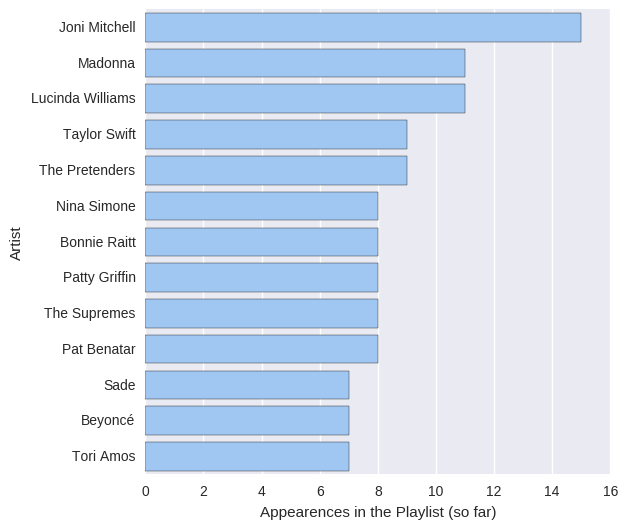

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'Count'))
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Count', data=artists[artists['Count'] > 6], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

#### Word Cloud of Artists
Just for fun, we can turn that list into a word cloud

<function matplotlib.pyplot.show>

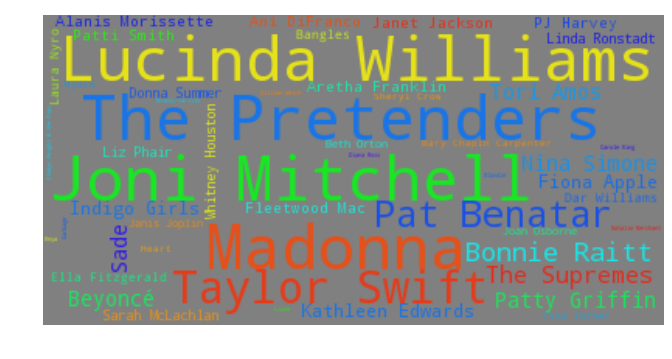

In [4]:
from wordcloud import WordCloud
from collections import Counter
artist_counts = Counter(playlist['Artist'].tolist()).most_common(50)
wordcloud = WordCloud(max_font_size=40, stopwords='', background_color='gray').generate_from_frequencies(artist_counts)
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show

### Popular Albums

On a short, 885 track, countdown, you might not expect too many tracks from the same album.
But even this soon, there are a few albums with two tracks.


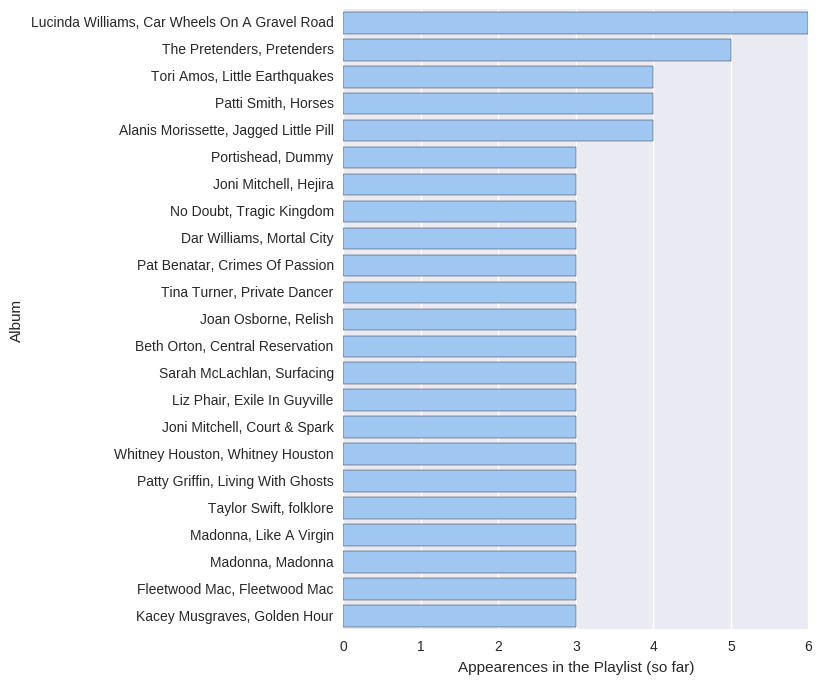

In [5]:
albums = playlist.groupby(['Artist', 'Album']).size().reset_index().rename(columns={0:'Count'})
albums = albums.sort_values(by=['Count'], ascending=False)
albums["label"] = albums['Artist'] + ', ' + albums['Album']
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='label', x='Count', data=albums[albums['Count'] > 2], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")
ax.set(ylabel="Album")


## Tracks by Year

It's always interesting to see the distribution over time.
XPN listeners are pretty diverse with broad tastes,
so there's usually a spread here.

One catch is that I'm back to using Musicbrainz for publication dates.
So I likely won't have years for all tracks.

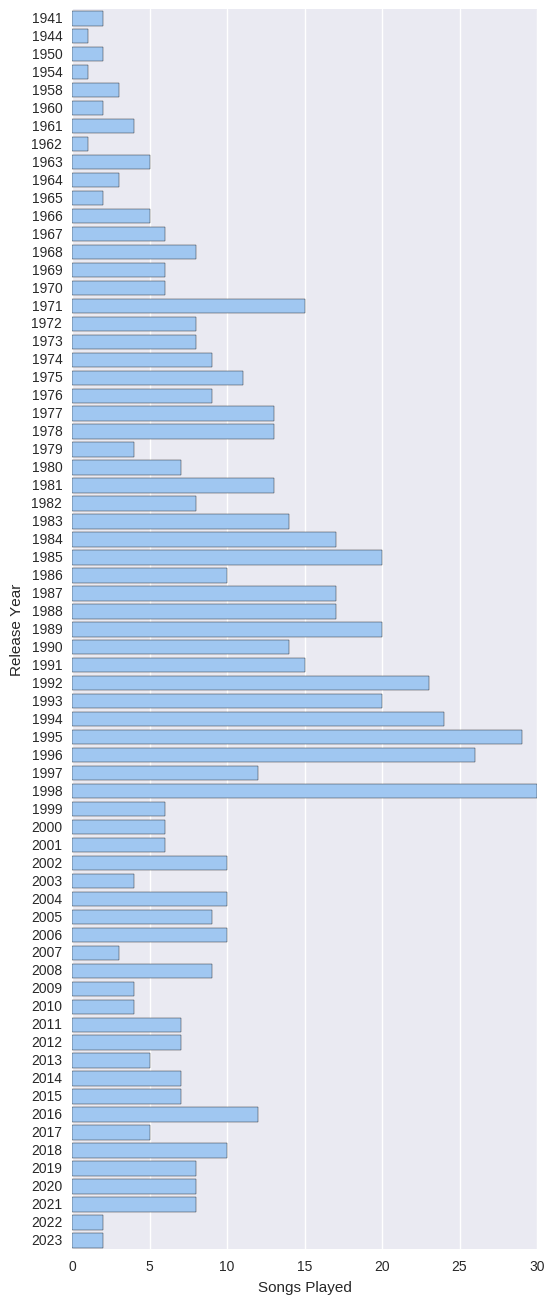

In [6]:
f, ax = plt.subplots(figsize=(6, 16))
sns.set_color_codes('pastel')
sns.countplot(y='Year', data=playlist[playlist['Year'] > 0], color='b')
ax.set(xlabel="Songs Played", ylabel="Release Year")

### Tracks by First Word

Back in the original A-Z, the first thing I did was break things down by first word.
The whole "how much does counting 'the' and 'a' matter, 
is kind of what got this effort started.


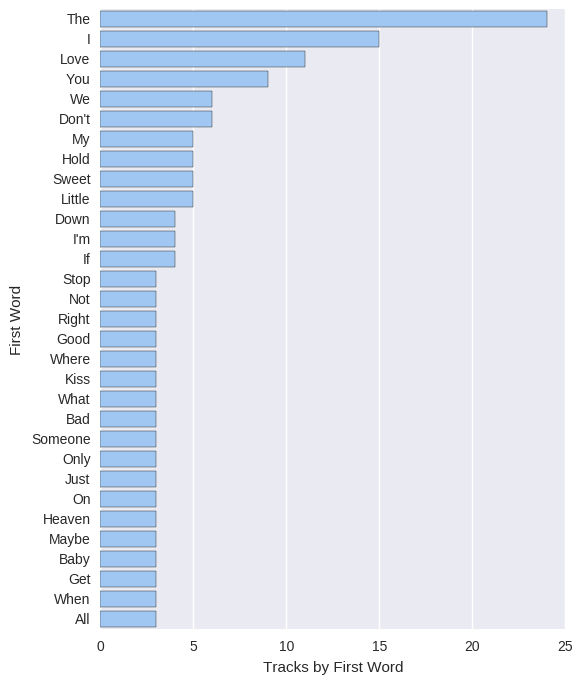

In [7]:
c = playlist['First Word'].value_counts()
words = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('First Word', 'Count'))
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='First Word', x='Count', data=words[words['Count'] > 2], color='b')
ax.set(xlabel="Tracks by First Word")

### Longest Songs
At some level the duration we calculate is somewhat suspect.
There are station id breaks, and such.
So just counting start to start is iffy.
I may go back and pull this from Musicbrainz,
since I need that for years and it will be more accurate.
But it's still interesting.

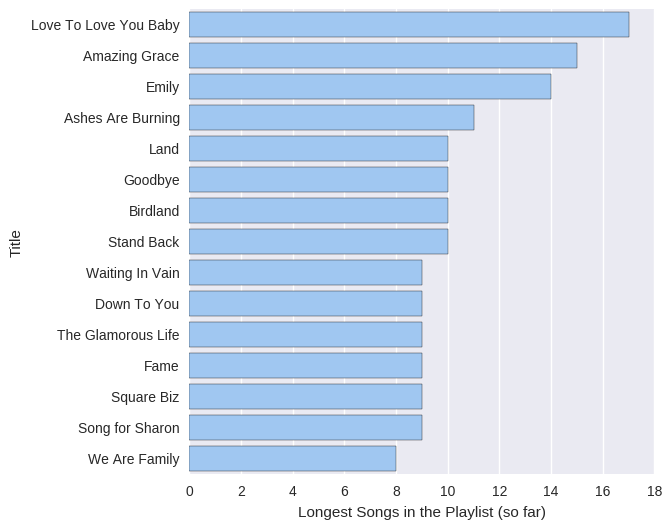

In [8]:
long_songs = playlist.sort_values(by='Duration', ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Title', x='Duration', data=long_songs.head(15), color='b')
ax.set(xlabel="Longest Songs in the Playlist (so far)")

## Sequential Runs by an Artist

How often do we get runs of two or more consecutive tracks by the same artist?
Those would have to have the same or "off by one" vote counts.
Depending on how the playlist is orders among ties, this might happen a bit.
But the two I see so far look like issues with the play list.

In [9]:
def sequential_runs(tracks):
    runs = pd.DataFrame(None, columns = ['Artist', 'Songs'])
    artist = None
    titles = []
    for idx in tracks.index:
        if tracks['Artist'][idx] == artist:
            titles.append(tracks['Title'][idx])
        else:
            if len(titles) > 1:
                runs = runs.append({'Artist': artist,
                                   'Songs': titles},
                                  ignore_index=True)
            artist = tracks['Artist'][idx]
            titles = [tracks['Title'][idx]]
    return runs

In [10]:
HTML(sequential_runs(playlist).to_html(index=False))

Artist,Songs
Joni Mitchell,"[Blue Motel Room, Hissing Of Summer Lawns]"
The Supremes,"[Someday We'll Be Together, Where Did Our Love..."
Linda Ronstadt,"[Heart Like A Wheel, Lose Again]"
Alanis Morissette,"[Uninvited, Thank U]"
Lucinda Williams,"[Right In Time, Joy]"
Nina Simone,"[I Wish I Knew How It Would Feel To Be Free, S..."


### Duplicate Titles

It's hard to tell if the "same song" with diffrent artists has been played.
    But "same song title" is a decent approximation.

In [11]:
def duplicate_titles(tracks):
    # first find the titles that apper more than once
    titles = playlist.groupby(['Title']).size().reset_index().rename(columns={0:'Count'})
    dups = titles[titles['Count'] > 1]
    dups['Artists'] = [[] for _ in range(len(dups))]
    
    
    # now go back and find the artists
    for x in dups.iterrows():
        tracks = playlist[playlist['Title'] == x[1]['Title']]
        for y in tracks.iterrows():
            x[1]['Artists'].append(y[1]['Artist'])
    
    return dups

In [12]:
HTML(duplicate_titles(playlist).to_html(index=False))

Title,Count,Artists
Beautiful,2,"[Christina Aguilera, Carole King]"
Hold On,3,"[Wilson Phillips, Sarah McLachlan, Alabama Sha..."
I Can't Stand The Rain,2,"[Tina Turner, Ann Peebles]"
Maybe,2,"[The Chantels, Janis Joplin]"
On The Radio,2,"[Regina Spektor, Donna Summer]"
Someone To Lay Down Beside Me,2,"[Linda Ronstadt, Karla Bonoff]"
Stoney End,2,"[Barbra Streisand, Laura Nyro]"
Up On The Roof,2,"[Laura Nyro, Carole King]"
We Belong Together,2,"[Mariah Carey, Rickie Lee Jones]"


### How did my votes do?

Like a lot of XPN listeners, I voted on this countdown.
so how did my votes do?

In [13]:
votes_file = path.join(data_dir, '885_women_my_votes.csv')
votes = pd.read_csv(votes_file)
votes = votes.merge(playlist, how='left', on=['Artist', 'Title'], suffixes=[None, '_y'], indicator=True)
votes['In Countdown Yet'] = votes.apply(lambda x: 'Yes' if x['_merge'] == 'both' else 'No', axis=1)
HTML(votes.to_html(columns=['Artist', 'Title', 'In Countdown Yet'], index=False))

Artist,Title,In Countdown Yet
Gillian Welch,April The 14th (part 1),No
Nanci Griffith,Love At The Five & Dime,Yes
Brandi Carlile,The Story,No
Dar Williams,Iowa,Yes
Janis Joplin,Me and Bobbie McGee,No
Bonnie Raitt,Angel From Montgomery,No
Emmylou Harris,Red Dirt Girl,No
Linda Ronstadt,Back In The U.S.A.,No
Mavis Staples,Freedom Highway,No
Joni Mitchell,The Circle Game,No


## Availability
The code for this project is in [my github repo](https://github.com/asudell/a2z)
and this file is specifically [885SongsByWomen.ipynb](https://github.com/asudell/a2z/blob/master/885SongsByWomen.ipynb).

## License


This project is licensed under a
[Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).
You are free to use for commercial or non-commercial purposes,
so long as you attribute the source and also allow sharing.